In [12]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage.interpolation import shift
import os
import seaborn as sns
%matplotlib inline

In [13]:
#dat_path = '../../../dat'DATASETS\NL 14614829 - Claim File- image 1_Part 1\Output
dat_path = "../../../dat/DATASETS/NL 14614829 - Claim File- image 1_Part 1/Output"

In [28]:
#file_name = 'Page 3.jpg' # OK
#file_name = 'Page 5.jpg' # OK
file_name = 'Page 7.jpg' # OK
#file_name = 'Page 8.jpg' # NOK

img_orig = cv2.imread(os.path.join(dat_path, file_name), 0)
img = (255 - img_orig)/255

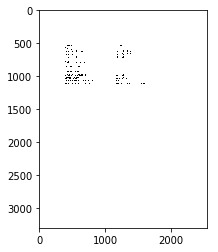

In [15]:
plt.imshow(img_orig,cmap='gray')

In [16]:
img.shape

(3300, 2550)

In [6]:
def maxpool1D(h, w):
    #w = 100
    n_w = int(len(h)/w)
    h_maxes = np.zeros(len(h))
    for i in range(n_w):
        #print(i+w)
        #print(max(h_all[i*w:(i+1)*w]))
        h_maxes[i*w:(i+1)*w] = max(h_all[i*w:(i+1)*w]) 
    return h_maxes

In [7]:
 
def remove_consecutive(input): 
    '''
    result = input.copy()
    last_val = 0
    for idx, val in enumerate(input):
        if(last_val != 0):
            if val == last_val:
                result[idx] = 0
        if(val == 1 or val == -1):
            last_val = val
        
            
    return result
    '''
    '''
    
    a = np.int64(input) # bitwise do not work float64   
    return a ^ (shift(a, 1, cval=0) & a)        # This won't work, since we need to remove non-alternating 1's or -1's, but not necessarily direct neighbors
    '''
    
    # Get 1's pos
    ones = np.squeeze(np.argwhere(input == 1))
    # Get -1's pos
    neg_ones = np.squeeze(np.argwhere(input == -1))
    # Alternate from 1's and -1's. Always start by 1's
    result = []
    positive = True
    next_pos = 0
    for i in range(len(ones)):
        if positive:
            result.append(ones[next_pos])
            positive = False
            curr_pos = next_pos

            next_pos = np.squeeze(np.argwhere(neg_ones > ones[curr_pos])).tolist()# Alternate to the pos in neg_ones > curr_pos value in ones
            if isinstance(next_pos, list):
                if len(next_pos) > 0:
                    next_pos = next_pos[0]
                else:
                    break
            else:
                next_pos = next_pos
        else:
            result.append(neg_ones[next_pos])
            positive = True
            curr_pos = next_pos

            next_pos = np.squeeze(np.argwhere(ones > neg_ones[curr_pos])).tolist()
            if isinstance(next_pos, list):
                if len(next_pos) > 0:
                    next_pos = next_pos[0]
                else:
                    break
            else:
                next_pos = next_pos
    
    mask = np.zeros(len(input), dtype=int)
    if(len(result) > 0):
        mask[np.array(result)] = input[np.array(result)]

    return mask

In [8]:
def remove_false_cols(grads):
    min_col_width = 50
    # Get all posititions of col starts
    
    col_starts = np.squeeze(np.argwhere(grads==1))
    # If dist between 2 1's < min_col_width--> set all to zeros until next 1 pos
    prev_pos = col_starts[0]
    for idx, pos in enumerate(col_starts):
        if idx > 0:
            dist = pos - prev_pos
            if dist < min_col_width:
                if idx + 1 < len(col_starts):
                    next_pos = col_starts[idx+1]
                    grads[pos:next_pos-1] = 0
                else:
                    # Suppress all till end
                    grads[pos:] = 0

    return grads

In [9]:
def clean_grads(grads):
    # TODO: outliers removal
    
    # Adaptive threshold = max*ratio
    ratio = 0.5
    thresh = np.max(grads)*ratio   
    
    # Filter pos values
    filter_pos_idx = np.squeeze(np.argwhere(np.logical_and((grads > 0), (grads <= thresh))))
    grads[filter_pos_idx] = 0
    
    # Filter neg values
    filter_neg_idx = np.squeeze(np.argwhere(np.logical_and((grads < 0), (grads >= -thresh))))
    grads[filter_neg_idx] = 0
 
    # Normalize thr grads to 1/-1
    grads[grads < 0] = -1
    grads[grads > 0] = 1

    # Remove consecutive 1's or -1's
    grads = remove_consecutive(grads)
    
    return grads

In [10]:
def row_pattern_detect(row_grads):
    
    if len(np.argwhere(row_grads==1)) >= 2:

        # If dist between 2 1's < min_col_width--> set all to zeros
        row_grads = remove_false_cols(row_grads)

        # Count 1's => 2
        if len(np.argwhere(row_grads==1)) >= 2:
            col_positions = np.squeeze(np.argwhere(row_grads==1))                   
        else:
            col_positions = []
    else:
        col_positions = []
    
    return col_positions
    

In [11]:

strip_height = 50
H, W = img.shape
n_strips = int(np.floor(H/strip_height))

tables = []
table_info = {}
table_registered = False
table_ended = 0
#borders = []
img_borders = np.zeros([n_strips * strip_height, W])
for i in range(n_strips):
    start = i*strip_height
    end = start + strip_height
    
    # 1. Img strip
    img_strip = img[start:end, :]  
    # 2. Histo projection
    h_all = np.sum(img_strip, axis=0)
    # 3. Maxpool1D
    h_maxes = maxpool1D(h_all, w=200)
    # 4. Gradients
    g = np.gradient(h_maxes)
    # 5. Clean grads
    g_clean = clean_grads(g)

    col_positions = row_pattern_detect(g_clean)
    if table_registered == False:
        if len(col_positions) > 0:      
            table_info['table_start'] = start
            table_info['col_positions'] = col_positions
            table_registered = True
            color = 'b'
        else:
            color = 'r'
            
    else:
        if table_registered == True:
            if len(col_positions) == 0:
                table_ended += 1
                if table_ended >= 2:
                    table_info['table_end'] = end
                    tables.append(table_info)
                    table_info = {}
                    table_registered = False
                    table_ended = 0                    
    
    #borders.append(np.tile(g_clean,strip_height).reshape(strip_height,len(g_clean)))
    g_clean[g_clean < 0] = 0
    img_borders[start:end, :] = np.tile(g_clean,strip_height).reshape(strip_height,len(g_clean))                    
    
    '''
    fig = plt.figure()    
    # Show the orig image with the strip on col 1
    ax = fig.add_subplot(211)
    rect = patches.Rectangle((0,end), W, strip_height,linewidth=1,edgecolor=color,facecolor='none')
    n_cols = len(col_positions)
    ax.add_patch(rect)
    ax.text(10,10,str(n_cols))
    ax.imshow(img_orig, cmap='gray')

    # Show next the cleaned up grad or histogram
    ax = fig.add_subplot(221)
    ax.plot(g_clean)
    '''
    
    #ax.imshow(img_borders[start:end, :])

    
    
    


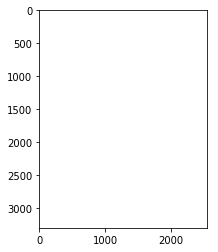

In [12]:
plt.imshow(255 - img_borders,cmap='gray')

In [13]:
'''
len(borders)
borders[60].shape
img_borders = np.zeros([len(borders) * borders[0].shape[0], borders[0].shape[1]])
img_borders[100:200, :] = 1
plt.imshow(img_borders,cmap='gray')
'''

"\nlen(borders)\nborders[60].shape\nimg_borders = np.zeros([len(borders) * borders[0].shape[0], borders[0].shape[1]])\nimg_borders[100:200, :] = 1\nplt.imshow(img_borders,cmap='gray')\n"

In [14]:
tables

[{'table_start': 500, 'col_positions': array([199, 999]), 'table_end': 850},
 {'table_start': 950, 'col_positions': array([199, 999]), 'table_end': 1200}]

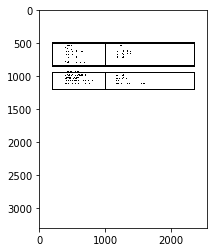

In [15]:
#tables_img = np.ones(img.shape)
tables_img = img_orig
#plt.imshow(tables_img, cmap='gray')
#start = (199, 1250)
#end = (199, 1900)
#for table in tables:
line_width = 10
#tables_img[start[1]:end[1], start[0]-line_width:start[0]+line_width] = 0
#plt.imshow(tables_img, cmap='gray')

for table in tables:
    table_start = table['table_start']
    table_end = table['table_end']
    # Last colomn boundary = min(img_boundary, last_col_start + spacing of the previous colomn)
    #last_col = min(tables_img.shape[1], table['col_positions'][-1] + (table['col_positions'][-1] - table['col_positions'][-2]))
    last_col = tables_img.shape[1] - table['col_positions'][0]
    # Draw table boundaries
    tables_img[table_start-line_width:table_start+line_width, table['col_positions'][0] : last_col] = 0
    tables_img[table_end-line_width:table_end+line_width, table['col_positions'][0] : last_col] = 0
    # Draw cols
    for col in table['col_positions']:
        
        tables_img[table_start:table_end, col-line_width:col+line_width] = 0
    # Left boundary
    tables_img[table_start:table_end, last_col-line_width:last_col+line_width] = 0
plt.imshow(tables_img, cmap='gray')
plt.imsave(file_name + '_table.jpg', tables_img, cmap='gray')

In [24]:
class TableDetector:

    def __init__(self):
        self.state = 'Table_Search'
        self.state_machine = {'Table_Search':self.table_search, 
                              'Candidate_Table': self.candidate_table, 
                              'Table_Registered':self.table_registered, 
                              'Confirm_Table_End':self.confirm_table_end}
        self.tables = []
        self.reset_table_info()
        self.strip_height = 50
        self.w_max_pool = 200
        self.min_col_width = 50
        self.ratio_clip_max = 0.5
        
    def reset_table_info(self):
        
        self.table_info = {}
        self.col_positions = []
        
    def table_search(self):
        print('Table_Search')
        if len(self.col_positions) > 0:      
            self.state = 'Candidate_Table'
            self.table_info['table_start'] = self.start
            self.table_info['col_positions'] = self.col_positions
            
        return
    
    def candidate_table(self):
        print('Candidate_Table')
        if len(self.col_positions) > 0:      
            self.state = 'Table_Registered'
        else:
            self.state = 'Table_Search'
            self.reset_table_info()
        return
    
    def table_registered(self):
        print('Table_Registered')
        if len(self.col_positions) == 0:
            self.state = 'Confirm_Table_End'
        return
    
    def confirm_table_end(self):
        print('Confirm_Table_End')
        if len(self.col_positions) == 0:
            self.state = 'Table_Search'
            self.table_info['table_end'] = self.end
            self.tables.append(self.table_info)
            self.reset_table_info()
        else:
            self.state = 'Table_Registered'
        return
    
    def remove_false_cols(self, grads):
        self.min_col_width = 50
        # Get all posititions of col starts

        col_starts = np.squeeze(np.argwhere(grads==1))
        # If dist between 2 1's < min_col_width--> set all to zeros until next 1 pos
        prev_pos = col_starts[0]
        for idx, pos in enumerate(col_starts):
            if idx > 0:
                dist = pos - prev_pos
                if dist < self.min_col_width:
                    if idx + 1 < len(col_starts):
                        next_pos = col_starts[idx+1]
                        grads[pos:next_pos-1] = 0
                    else:
                        # Suppress all till end
                        grads[pos:] = 0

        return grads   
 
    def remove_consecutive(self, input): 
        # Get 1's pos
        ones = np.squeeze(np.argwhere(input == 1))
        # Get -1's pos
        neg_ones = np.squeeze(np.argwhere(input == -1))
        # Alternate from 1's and -1's. Always start by 1's
        result = []
        positive = True
        next_pos = 0
        for i in range(len(ones)):
            if positive:
                result.append(ones[next_pos])
                positive = False
                curr_pos = next_pos

                next_pos = np.squeeze(np.argwhere(neg_ones > ones[curr_pos])).tolist()# Alternate to the pos in neg_ones > curr_pos value in ones
                if isinstance(next_pos, list):
                    if len(next_pos) > 0:
                        next_pos = next_pos[0]
                    else:
                        break
                else:
                    next_pos = next_pos
            else:
                result.append(neg_ones[next_pos])
                positive = True
                curr_pos = next_pos

                next_pos = np.squeeze(np.argwhere(ones > neg_ones[curr_pos])).tolist()
                if isinstance(next_pos, list):
                    if len(next_pos) > 0:
                        next_pos = next_pos[0]
                    else:
                        break
                else:
                    next_pos = next_pos

        mask = np.zeros(len(input), dtype=int)
        if(len(result) > 0):
            mask[np.array(result)] = input[np.array(result)]

        return mask 
    
    def maxpool1D(self, h, w):
        #w = 100
        n_w = int(len(h)/w)
        h_maxes = np.zeros(len(h))
        for i in range(n_w):
            #print(i+w)
            #print(max(h_all[i*w:(i+1)*w]))
            h_maxes[i*w:(i+1)*w] = max(h[i*w:(i+1)*w]) 
            
        return h_maxes    
    
    def clean_grads(self, grads):
        # TODO: outliers removal

        # Adaptive threshold = max*ratio       
        thresh = np.max(grads)*self.ratio_clip_max   

        # Filter pos values
        filter_pos_idx = np.squeeze(np.argwhere(np.logical_and((grads > 0), (grads <= thresh))))
        grads[filter_pos_idx] = 0

        # Filter neg values
        filter_neg_idx = np.squeeze(np.argwhere(np.logical_and((grads < 0), (grads >= -thresh))))
        grads[filter_neg_idx] = 0

        # Normalize thr grads to 1/-1
        grads[grads < 0] = -1
        grads[grads > 0] = 1

        # Remove consecutive 1's or -1's
        grads = self.remove_consecutive(grads)

        return grads    
    def preprocess_row(self, img_strip):

        # 1. Histo projection
        h_all = np.sum(img_strip, axis=0)
        # 2. Maxpool1D
        h_maxes = self.maxpool1D(h_all, w=self.w_max_pool)
        # 3. Gradients
        g = np.gradient(h_maxes)
        # 4. Clean grads
        g_clean = self.clean_grads(g)   
        
        return g_clean
    
    def check_row_pattern(self, row_grads):

        if len(np.argwhere(row_grads==1)) >= 2:

            # If dist between 2 1's < min_col_width--> set all to zeros
            row_grads = self.remove_false_cols(row_grads)

            # Count 1's => 2
            if len(np.argwhere(row_grads==1)) >= 2:
                col_positions = np.squeeze(np.argwhere(row_grads==1))                   
            else:
                col_positions = []
        else:
            col_positions = []

        return col_positions
    
    def row_pattern_detect(self, img_strip):
        g_clean = self.preprocess_row(img_strip)
        col_positions = self.check_row_pattern(g_clean)
        return col_positions
    
    def run(self, img):
        H, W = img.shape
        n_strips = int(np.floor(H/self.strip_height))
        
        for i in range(n_strips):
            self.start = i*self.strip_height
            self.end = self.start + self.strip_height
            img_strip = img[self.start:self.end, :] 
            self.col_positions = self.row_pattern_detect(img_strip)
            self.state_machine[self.state]()
            
        return self.tables
   
   
    


In [29]:
tables_detector = TableDetector()
tables = tables_detector.run(img)

Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Candidate_Table
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Candidate_Table
Table_Registered
Table_Registered
Table_Registered
Table_Registered
Table_Registered
Table_Registered
Table_Registered
Table_Registered
Table_Registered
Table_Registered
Confirm_Table_End
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search
Table_Search


In [30]:
tables

[{'table_start': 1250,
  'col_positions': array([ 199,  799, 1799]),
  'table_end': 1900}]

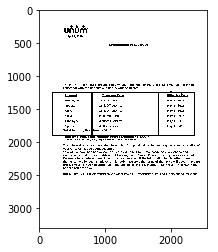

In [31]:
#tables_img = np.ones(img.shape)
tables_img = img_orig
#plt.imshow(tables_img, cmap='gray')
#start = (199, 1250)
#end = (199, 1900)
#for table in tables:
line_width = 10
#tables_img[start[1]:end[1], start[0]-line_width:start[0]+line_width] = 0
#plt.imshow(tables_img, cmap='gray')

for table in tables:
    table_start = table['table_start']
    table_end = table['table_end']
    # Last colomn boundary = min(img_boundary, last_col_start + spacing of the previous colomn)
    #last_col = min(tables_img.shape[1], table['col_positions'][-1] + (table['col_positions'][-1] - table['col_positions'][-2]))
    last_col = tables_img.shape[1] - table['col_positions'][0]
    # Draw table boundaries
    tables_img[table_start-line_width:table_start+line_width, table['col_positions'][0] : last_col] = 0
    tables_img[table_end-line_width:table_end+line_width, table['col_positions'][0] : last_col] = 0
    # Draw cols
    for col in table['col_positions']:
        
        tables_img[table_start:table_end, col-line_width:col+line_width] = 0
    # Left boundary
    tables_img[table_start:table_end, last_col-line_width:last_col+line_width] = 0
plt.imshow(tables_img, cmap='gray')
plt.imsave(file_name + '_table.jpg', tables_img, cmap='gray')